In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Sens = np.genfromtxt('subsfin.txt') # dados dos sensores
Locs = np.genfromtxt('mote_locs.txt') # Cordenadas dos sensores [mote id, x, y]

In [3]:
print(Sens.shape)
print(Locs.shape)

(14400, 52)
(54, 3)


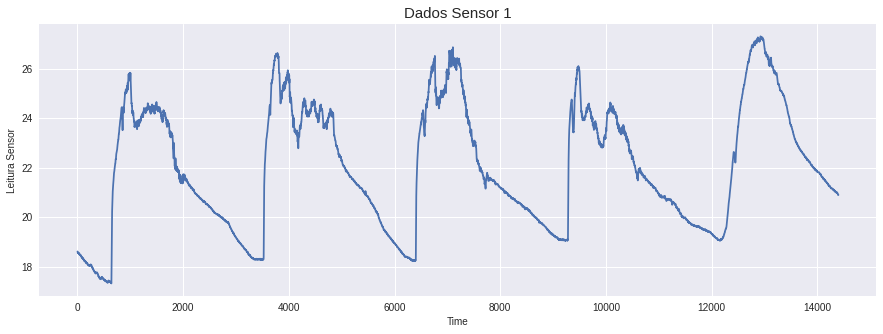

In [4]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(Sens[:,0])
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('Dados Sensor 1', fontsize=15)
plt.show()

## 2.1. Tratamento do ruido via alisamento exponencial simples

* Tabelas 1 e 2 (52x10) mostram o erro absoluto médio (MAE) entre a série original e a série alisada para 10 valores de $\alpha$ 
\begin{equation}
    MAE = \frac{1}{N}\sum_{i=1}^{N} |S_i - X_i|
\end{equation}

In [5]:
def MAE(list_st_lisa, list_st_normal):
    lista_erro = []
    for i in range(0, np.shape(list_st_lisa)[0]):
        soma = 0
        for j in range(0 , np.shape(list_st_lisa)[1]):

            soma += abs(list_st_lisa[i][j] - list_st_normal[:,i][j]) 
        erro = (1/len(list_st_lisa)) * soma 
        lista_erro.append(erro)

    return lista_erro

* Tratamento do ruido via alisamento exponencial simples \cite{wiki}} O objetivo deste item é implementar e entender o efeito do alisamento exponencial simples para atenuar o ruido numa série temporal. Seja $S(t)$ a versão alisada da série temporal $X(t), t = 1, ..., N$ onde $N$ é o tamanho da série. Então $S(t)$ é obtida de $X(t)$ pela equação:

\begin{equation}
   S(1) = X(1)  
\end{equation}

\begin{equation}
    S(t) = \alpha X(t) + (1 - \alpha) S(t -1), t = 2, ..., N 
\end{equation}

In [6]:
alfa_valor = [0.157, 0.234, 0.345, 0.456, 0.543, 0.688, 0.734, 0.888, 0.923, 0.999]

list_st_lisa = []
lista_erro_st = []
for i in range(0, len(alfa_valor)): # percorrendo todos os valores de alfa
    
    lista_alisa = []
    
    for j in range(0, Sens.shape[1]): # Percorrendo todos os sensores
        
        list_s = [] #lista criada para cada sensor
        
        list_s.append(Sens[:,j][0]) # pegando primeiro valor da serie
        
        alfa = alfa_valor[i] # pegando o primeiro valor de alfa
        
        for k in range(1, len(Sens[:,0])): # aplicado a formula em serie de um sensor 
            
            s =  (alfa * Sens[:,j][k]) + ((1 - alfa) * list_s[k-1])
            
            list_s.append(s) # Pegando todos os valores de uma serie lisa
            
        lista_alisa.append(list_s) # Pegando todas as series lisas para um alfa
        
    list_st_lisa.append(lista_alisa) # Pegando o daset todo alisado cm um valor de alfa
    erro_st = MAE(lista_alisa, Sens) # Calculando o erro MAE
    lista_erro_st.append(erro_st) # Quando os erros para da alfa
            
    

In [7]:
print(np.array(list_st_lisa).shape)
print(np.array(lista_erro_st).shape)

(10, 52, 14400)
(10, 52)


In [8]:
# Salvando dos dados das tabelas
np.savetxt('resultados/2.1/erro_alisa.txt', np.array(lista_erro_st).T, fmt='%4.3f', delimiter='&')

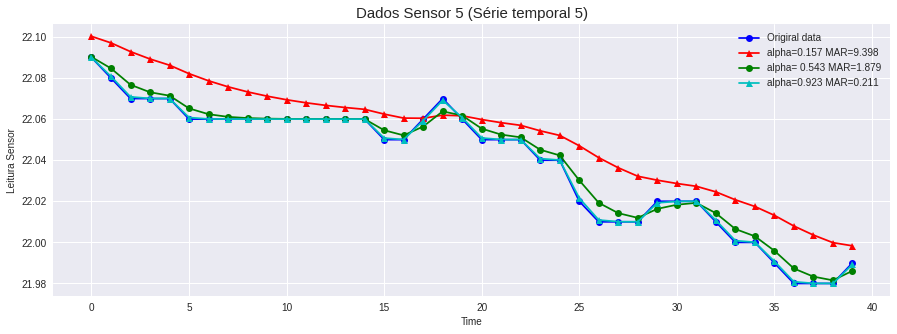

In [9]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(Sens[:,4][5000:5040],'bo-', label='Origiral data')
plt.plot(list_st_lisa[0][4][5000:5040],'r^-', 
         label='alpha=0.157 MAR='+str(lista_erro_st[0][4])[:5] )
plt.plot(list_st_lisa[4][4][5000:5040],'go-', 
         label='alpha= 0.543 MAR='+str(lista_erro_st[4][4])[:5] )
plt.plot(list_st_lisa[8][4][5000:5040],'c^-', 
         label='alpha=0.923 MAR='+str(lista_erro_st[8][4])[:5])
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('Dados Sensor 5 (Série temporal 5)', fontsize=15)
plt.savefig("resultados/2.1/alisa_sensor_5.png", bbox_inches='tight')
plt.show()

## 2.2. Determinação da similaridade espacial (entre séries) baseada na matriz de correlação

* Seja X a matriz de dados. As dimensões de $X$ para o dataset dado é 14400 x 52, ou seja, cada coluna de $X$ é uma série temporal. Sejam $m$ o vetor de médias e $v$ o vetor de variâncias das colunas de $X$, ou seja, as médias e as variâncias das séries temporais. As matrizes de correlação R, de covariâncias C e de coeficientes de correlação $Ro$ são dadas por:

\begin{equation}
     R_X = \frac{1}{5760} X'X = \frac{1}{5760} [ R_{ij} = \sum_{k=1}^{14400} X_{ik}X_{jk} ]
\end{equation}

\begin{equation}
    C_X = \frac{1}{5760} (X - m)'(X - m) = \frac{1}{5760} [ C_{ij} = \sum_{k=1}^{5760} (X_{ik} - m_i)(X_{jk} - m_k) ]
\end{equation}

\begin{equation}
    Ro_X = [ Ro_{ij} = \frac{C_{ij}}{\sqrt{v_iv_j}} ]
\end{equation}

In [10]:
# Separando os dados em treinamneto e teste
Xtr = Sens[0:5760] # treinamento
Xte = Sens[5760:14400 ] # teste

In [11]:
R_x = (1/5760) * np.dot(Xtr.T, Xtr)

In [12]:
R_x.shape

(52, 52)

In [13]:
R_x

array([[481.35765319, 475.42056816, 480.41339998, ..., 453.4966258 ,
        442.52103047, 437.94580943],
       [475.42056816, 469.97099073, 474.73167644, ..., 447.89955293,
        436.66363012, 431.97200262],
       [480.41339998, 474.73167644, 479.69985137, ..., 452.72115887,
        441.45063493, 436.70256049],
       ...,
       [453.4966258 , 447.89955293, 452.72115887, ..., 428.82598714,
        417.92602832, 413.17974274],
       [442.52103047, 436.66363012, 441.45063493, ..., 417.92602832,
        408.1488749 , 403.91544773],
       [437.94580943, 431.97200262, 436.70256049, ..., 413.17974274,
        403.91544773, 400.069225  ]])

In [14]:
#  Calculando a matriz de covariancia de acordo com a formula
mean_x = np.mean(Xtr, axis=0)
X_central = Xtr - mean_x
C_x = (1/5760) * np.dot(X_central.T, X_central)
print(mean_x.shape)
print(C_x.shape)
C_x

(52,)
(52, 52)


array([[ 6.22785792,  4.76523385,  5.54483379, ...,  6.56810491,
         7.69824287,  8.03146442],
       [ 4.76523385,  3.74797986,  4.33511113, ...,  5.1799119 ,
         5.93571852,  6.10630911],
       [ 5.54483379,  4.33511113,  5.09237063, ...,  6.03836184,
         6.86691539,  7.02458485],
       ...,
       [ 6.56810491,  5.1799119 ,  6.03836184, ...,  8.42485723,
         8.9120973 ,  8.78291427],
       [ 7.69824287,  5.93571852,  6.86691539, ...,  8.9120973 ,
        10.2137033 , 10.47231748],
       [ 8.03146442,  6.10630911,  7.02458485, ...,  8.78291427,
        10.47231748, 11.06742827]])

In [15]:
# Usando o numpy para calcular amtriz de covariancia
cov_x = np.cov(Xtr, rowvar=False)
print(cov_x.shape)
cov_x

(52, 52)


array([[ 6.22893933,  4.7660613 ,  5.5457966 , ...,  6.5692454 ,
         7.6995796 ,  8.03285901],
       [ 4.7660613 ,  3.74863066,  4.33586389, ...,  5.18081135,
         5.9367492 ,  6.10736942],
       [ 5.5457966 ,  4.33586389,  5.09325488, ...,  6.03941035,
         6.86810777,  7.0258046 ],
       ...,
       [ 6.5692454 ,  5.18081135,  6.03941035, ...,  8.42632013,
         8.9136448 ,  8.78443934],
       [ 7.6995796 ,  5.9367492 ,  6.86810777, ...,  8.9136448 ,
        10.21547682, 10.47413591],
       [ 8.03285901,  6.10736942,  7.0258046 , ...,  8.78443934,
        10.47413591, 11.06935003]])

In [16]:
# Calculando o vetor de variância
v = np.var(Xtr, axis=0)
print(v.shape)
v

(52,)


array([ 6.22785792,  3.74797986,  5.09237063,  4.24340481,  3.84936815,
        4.10902306,  6.23232447,  6.81757758,  4.98770334, 11.77352796,
       14.28661505,  7.19728371,  8.79548533,  9.90561179,  7.02759845,
        7.42868787, 10.94980652, 12.74697588, 40.5158578 , 31.07498623,
       22.52821518, 31.41260739, 36.87147782, 21.95489142, 15.89348029,
       26.45634976, 19.44676851, 22.10972551, 19.42977056, 21.28956811,
       11.7103242 ,  4.59448654,  3.7952236 ,  4.37463383,  4.95681393,
        9.24209452,  5.4868901 , 10.02320534, 13.68981963, 14.60087564,
        9.66346641,  8.91117606,  8.40010317,  7.87399455,  7.53565385,
        6.17488272,  8.41458978,  9.61452418,  7.90003394,  8.42485723,
       10.2137033 , 11.06742827])

\begin{equation}
    Ro_X = [ Ro_{ij} = \frac{C_{ij}}{\sqrt{v_iv_j}} ]
\end{equation}

In [17]:
# Calculando a matriz de coeficente de correção 
Ro_x = []
for i in range(0, 52):
    ro = []
    for j in range(0, 52):
        ro.append(C_x[i][j] / np.sqrt(v[i] * v[j]))
    Ro_x.append(ro)

In [18]:
Ro_x = np.array(Ro_x)
print(Ro_x.shape)
Ro_x

(52, 52)


array([[1.        , 0.98631638, 0.98459853, ..., 0.90675395, 0.96522962,
        0.96739098],
       [0.98631638, 1.        , 0.99229684, ..., 0.92181225, 0.9593632 ,
        0.9481058 ],
       [0.98459853, 0.99229684, 1.        , ..., 0.92188735, 0.95216031,
        0.93570145],
       ...,
       [0.90675395, 0.92181225, 0.92188735, ..., 1.        , 0.96074255,
        0.90956557],
       [0.96522962, 0.9593632 , 0.95216031, ..., 0.96074255, 1.        ,
        0.98498093],
       [0.96739098, 0.9481058 , 0.93570145, ..., 0.90956557, 0.98498093,
        1.        ]])

In [19]:
# Função para calcular a similaridade entre as series

def simSetMax3(matriz_sim):
    sim_set_max = []
    sim_set_mim = []
    
    for i in range(0, 52):
        list_max_3 = []
        list_mim_3 = []
        
       
        st = list(matriz_sim[i])
        st[i] = 0 # Não pegando os das diagonais principais
        index_max = np.argsort(st)[::-1]
        
        # As 3 mais similares
        list_max_3.append(index_max[0]+1)
        list_max_3.append(index_max[1]+1)
        list_max_3.append(index_max[2]+1)
        
        # As 3 menos similares
        list_mim_3.append(index_max[50]+1)
        list_mim_3.append(index_max[49]+1)
        list_mim_3.append(index_max[48]+1)

        sim_set_max.append(list_max_3) # Pegnado o index da series mais similaries
        sim_set_mim.append(list_mim_3) # Pegnado o index da series menos similaries

    return sim_set_max, sim_set_mim # Retorna o index das 3 series mais similares entre se
    

In [20]:
# 2 Função para calcular a similaridade entre as series
def simMax3(matriz_sim):
    
    lis_max_st = []
    for i in range(0, np.array(matriz_sim).shape[0]):
        
        list_max3 = []
        
        st = matriz_sim[i]
        
        index_max = np.argsort(st)[::-1]
        
        for k in range(0, len(index_max)):
            if index_max[k] != i:
                list_max3.append(index_max[k]+1)
            if len(list_max3) == 3:
                break
        lis_max_st.append(list_max3)
        
    return lis_max_st
        

In [21]:
sim_teste,  sim_set_mim= simSetMax3(C_x)
print(len(sim_teste))
print(sim_teste)

52
[[19, 23, 22], [23, 19, 22], [23, 19, 22], [23, 19, 22], [19, 23, 22], [19, 23, 22], [19, 23, 20], [19, 23, 20], [19, 23, 20], [19, 23, 20], [19, 23, 20], [19, 23, 22], [19, 23, 20], [19, 23, 20], [19, 23, 20], [19, 23, 22], [19, 23, 22], [19, 23, 20], [23, 20, 22], [19, 23, 22], [19, 23, 20], [19, 23, 20], [19, 22, 20], [19, 23, 22], [19, 23, 22], [23, 19, 22], [19, 23, 22], [23, 19, 22], [19, 23, 22], [19, 23, 22], [19, 23, 22], [23, 22, 19], [23, 19, 22], [23, 22, 19], [23, 19, 22], [23, 22, 19], [23, 22, 19], [23, 19, 22], [23, 19, 22], [23, 19, 22], [23, 19, 22], [23, 19, 22], [19, 23, 20], [23, 19, 22], [23, 19, 22], [23, 22, 19], [23, 22, 19], [23, 22, 19], [23, 22, 19], [23, 19, 22], [19, 23, 22], [19, 23, 22]]


In [22]:
# Um teste para conferir
test_sim_max_cx = simMax3(C_x)
print(test_sim_max_cx)

[[19, 23, 22], [23, 19, 22], [23, 19, 22], [23, 19, 22], [19, 23, 22], [19, 23, 22], [19, 23, 20], [19, 23, 20], [19, 23, 20], [19, 23, 20], [19, 23, 20], [19, 23, 22], [19, 23, 20], [19, 23, 20], [19, 23, 20], [19, 23, 22], [19, 23, 22], [19, 23, 20], [23, 20, 22], [19, 23, 22], [19, 23, 20], [19, 23, 20], [19, 22, 20], [19, 23, 22], [19, 23, 22], [23, 19, 22], [19, 23, 22], [23, 19, 22], [19, 23, 22], [19, 23, 22], [19, 23, 22], [23, 22, 19], [23, 19, 22], [23, 22, 19], [23, 19, 22], [23, 22, 19], [23, 22, 19], [23, 19, 22], [23, 19, 22], [23, 19, 22], [23, 19, 22], [23, 19, 22], [19, 23, 20], [23, 19, 22], [23, 19, 22], [23, 22, 19], [23, 22, 19], [23, 22, 19], [23, 22, 19], [23, 19, 22], [19, 23, 22], [19, 23, 22]]


In [23]:
# Calculando as 3 seriés mais limilares entre se usando o C_x
sim_max_cx, sim_mim_cx = simSetMax3(C_x)
# Salvando dos dados das tabelas
np.savetxt('resultados/2.2/sim_max_cx.txt', np.array(sim_max_cx), fmt='%4.f', delimiter='&')
np.savetxt('resultados/2.2/sim_mim_cx.txt', np.array(sim_mim_cx), fmt='%4.f', delimiter='&')
print(sim_max_cx[24])
print(sim_mim_cx[24])

[19, 23, 22]
[33, 34, 46]


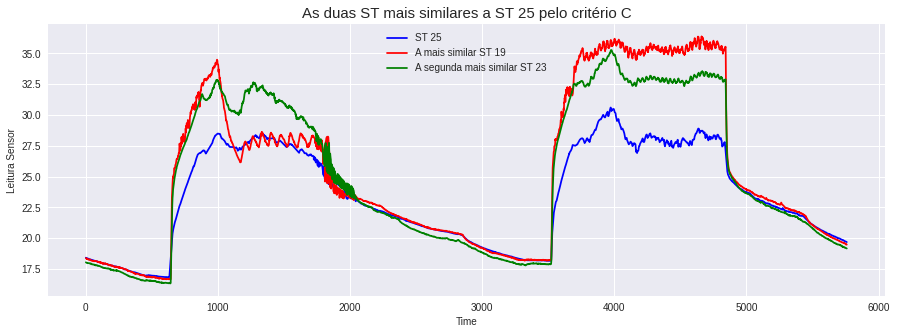

In [24]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(Xtr[:,24][:],'b', label='ST 25')
plt.plot(Xtr[:,18][:],'r', 
         label='A mais similar ST 19')
plt.plot(Xtr[:,22][:],'g', 
         label='A segunda mais similar ST 23')
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('As duas ST mais similares a ST 25 pelo critério C', fontsize=15)
plt.savefig("resultados/2.2/sim_c_max.png", bbox_inches='tight')
plt.show()

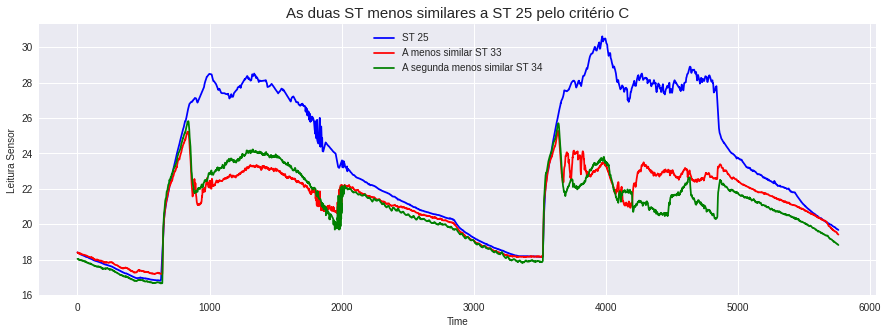

In [25]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(Xtr[:,24][:],'b', label='ST 25')
plt.plot(Xtr[:,32][:],'r', 
         label='A menos similar ST 33')
plt.plot(Xtr[:,33][:],'g', 
         label='A segunda menos similar ST 34')
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('As duas ST menos similares a ST 25 pelo critério C', fontsize=15)
plt.savefig("resultados/2.2/sim_c_mim.png", bbox_inches='tight')
plt.show()

In [26]:
# Calculando as 3 seriés mais limilares entre se usando o R_x
sim_max_rx, sim_mim_rx = simSetMax3(R_x)
# Salvando os dados das tabelas
np.savetxt('resultados/2.2/sim_max_rx.txt', np.array(sim_max_rx), fmt='%4.f', delimiter='&')
np.savetxt('resultados/2.2/sim_mim_rx.txt', np.array(sim_mim_rx), fmt='%4.f', delimiter='&')
print(sim_max_rx[40])
print(sim_mim_rx[40])

[19, 23, 22]
[48, 52, 51]


In [27]:
# Calculando as 3 seriés mais limilares entre se usando o Ro_x
sim_max_rox, sim_mim_rox = simSetMax3(Ro_x)
np.savetxt('resultados/2.2/sim_max_rox.txt', np.array(sim_max_rox), fmt='%4.f', delimiter='&')
np.savetxt('resultados/2.2/sim_mim_rox.txt', np.array(sim_mim_rox), fmt='%4.f', delimiter='&')
print(sim_max_rox[4])
print(sim_mim_rox[4])

[9, 6, 2]
[45, 47, 48]


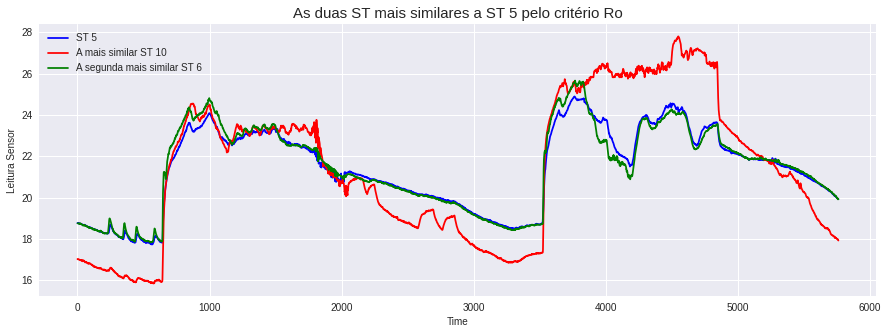

In [28]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(Xtr[:,4][:],'b', label='ST 5')
plt.plot(Xtr[:,9][:],'r', 
         label='A mais similar ST 10')
plt.plot(Xtr[:,5][:],'g', 
         label='A segunda mais similar ST 6')
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('As duas ST mais similares a ST 5 pelo critério Ro', fontsize=15)
plt.savefig("resultados/2.2/sim_ro_max.png", bbox_inches='tight')
plt.show()

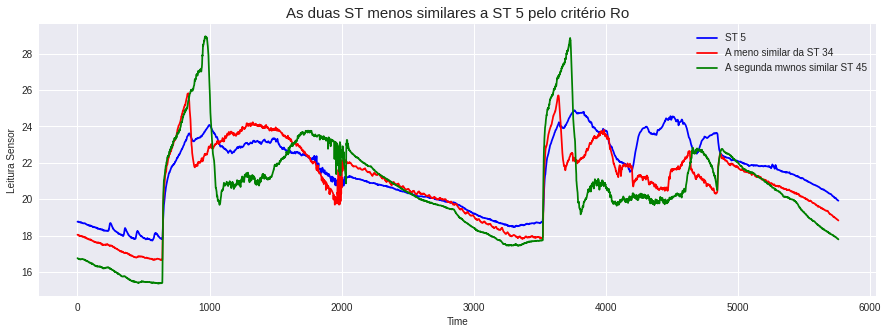

In [29]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(Xtr[:,4][:],'b', label='ST 5')
plt.plot(Xtr[:,33][:],'r', 
         label='A meno similar da ST 34')
plt.plot(Xtr[:,44][:],'g', 
         label='A segunda mwnos similar ST 45')
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('As duas ST menos similares a ST 5 pelo critério Ro', fontsize=15)
plt.savefig("resultados/2.2/sim_ro_mim.png", bbox_inches='tight')
plt.show()

## 2.3.1. Imputação com estimação espacial

Na Seção 2.2 foi obtida a lista das três STs mais correlacionadas com cada uma das séries. De forma genérica, sejam  ́$st_{.,u}, st_{.,v} e st_{.,w}$ as STs com maior correlação com $st_{.,i}$. Então forme a matriz $Xtr_i = [st_{.,i}, st_{.,u}, st_{.,v}, st_{.,w}]$, ou seja, as STs são as colunas de $Xtr_i$. Pelo método da subseção 2.2 obtenha $m_i$, o vetor de médias, e $C_{X_i}, i = 1, ..., M$, a matriz de covariâncias. Selecione aleatoriamente 10\% dos pontos em cada ST do conjunto de teste Xte como pontos ausentes e aplique o Teorema 12.7 para estimar os valores nestes pontos. Construa uma tabela do MAE para os pontos de teste ausentes comparando esta técnica de estimação espacial com as imputações pela média e pela repetiçãoo do ultimo valor recebido. Inclua no relatório tabelas, figuras, códigos e discussão no modelo fornecido para as Seções 2.1 e 2.2.

* Usando o criterio de similaridade $Ro$

In [30]:
# Xte  Dados de teste
# Xtr  Dados de treinamneto 
# As três mais similares usando o Ro sim_max_rox 
# As três mais similares usando o C sim_max_cx 
# As três mais similares usando o R sim_max_rx 


# Função para encontrar a matriz Xtr_i item 2.3.1
def StMax3(Xtr,list_max_sim):
    
    Xtr_i = []
    # Percorrendo as 52 series temporais
    for i in range(0, Xtr.shape[1]):
        # Pegando as 3 mais similares de cada uma das 52 series
        max_st3 = list_max_sim[i]
        # Aqui vai as 4 series temporais [st.,i, st.,u, st.,v, st.,w]
        list_st_sim = []
        # Pgando a serie st.,i
        list_st_sim.append(Xtr[:,i])
        
        # Pegando as series st.,u, st.,v, st.,w
        for j in range(0, len(max_st3)):
            list_st_sim.append(Xtr[:,max_st3[j]-1])
        # Junatdo as lista Xtr_i
        Xtr_i.append(list_st_sim)
    
    return np.array(Xtr_i)
    

In [31]:
# Criado a matrizes Xtr_i com as três mais similares usando o Ro sim_max_rox 
mat_Xtr_i_Ro = StMax3(Xtr, sim_max_rox)
print(mat_Xtr_i_Ro.shape)
print(mat_Xtr_i_Ro[0].shape)

(52, 4, 5760)
(4, 5760)


In [32]:
print(mat_Xtr_i_Ro[0])

[[18.61 18.6  18.59 ... 19.68 19.68 19.68]
 [19.04 19.04 19.03 ... 20.12 20.12 20.09]
 [18.82 18.8  18.79 ... 19.96 19.97 19.95]
 [18.76 18.77 18.77 ... 19.93 19.92 19.92]]


In [33]:
print(mat_Xtr_i_Ro[1])

[[19.04 19.04 19.03 ... 20.12 20.12 20.09]
 [18.82 18.8  18.79 ... 19.96 19.97 19.95]
 [18.61 18.6  18.59 ... 19.68 19.68 19.68]
 [18.76 18.77 18.77 ... 19.93 19.92 19.92]]


In [34]:
# Função para obter o vetor m_i e matriz Cx_i
def meanCxM(Xtr_i):
    list_Cx_i = []
    list_mi = []
    for i in range(0, 52):
        Str_i =  Xtr_i[i].T # Transformando para [5760, 4]
        # Encontrado o vetor m_i da Xtr_i
        m_i = np.mean(Str_i, axis=0)
        # Criando a matriz Cx_i
        Str_i_central = Str_i - m_i
        Cx_i = (1/5760) * np.dot(Str_i_central.T, Str_i_central)
        # juntando matriz com todos os Cx_i
        list_Cx_i.append(Cx_i)
        list_mi.append(m_i)
        
    return  np.array(list_Cx_i), np.array(list_mi) # Retorna matriz com todos os Cx_i e m_i
    

In [35]:
list_Cx_i_Ro, list_mi = meanCxM(mat_Xtr_i_Ro)
print(list_Cx_i_Ro.shape)

(52, 4, 4)


In [36]:
list_Cx_i_Ro[0]

array([[6.22785792, 4.76523385, 5.54483379, 4.80132899],
       [4.76523385, 3.74797986, 4.33511113, 3.72681988],
       [5.54483379, 4.33511113, 5.09237063, 4.32379028],
       [4.80132899, 3.72681988, 4.32379028, 3.84936815]])

In [37]:
list_Cx_i_Ro[1]

array([[3.74797986, 4.33511113, 4.76523385, 3.72681988],
       [4.33511113, 5.09237063, 5.54483379, 4.32379028],
       [4.76523385, 5.54483379, 6.22785792, 4.80132899],
       [3.72681988, 4.32379028, 4.80132899, 3.84936815]])

In [38]:
list_Cx_i_Ro[51]

array([[11.06742827, 10.47231748, 12.24411545, 10.70200134],
       [10.47231748, 10.2137033 , 11.42784606, 10.2952297 ],
       [12.24411545, 11.42784606, 14.28661505, 12.01522383],
       [10.70200134, 10.2952297 , 12.01522383, 10.94980652]])

### Aplicando o teorema 12.7

\begin{equation}
    \hat{X} = a'Y+b
\end{equation}

\begin{equation}
    Y = [X_1, X_2,X_3]
\end{equation}

\begin{equation}
    a' = C_{X,Y}C_{Y}^{-1}
\end{equation}

\begin{equation}
    b = E[X]-C_{X,Y}C_{Y}^{-1}E[Y] = E[X] - a'E[Y]
\end{equation}


In [39]:
def estimaLinear(mat_cov, mat_m):
    estima_x = []
    for i in range(0, 52): 
        # Encontrado a o valor esperado E[Y] (Media)
        E_Y = mat_m[i][1:]
        # Encontrado a matriz de covariancia de CY em C_X
        C_Y = mat_cov[i].copy()
        C_Y =  np.delete(C_Y, [0], axis=0) # removendo a linha de i
        C_Y =  np.delete(C_Y, [0], axis=1) # removendo a coluna de i
        C_x_y = mat_cov[i][1:,0] # matriz cruzada
        # Calculando o coeficiente a'
        a = np.dot(C_x_y, np.linalg.inv(C_Y))
        # Calculando o coeficente b
        b = mat_m[i][0] - np.dot(a.T, E_Y)
        
        estima_x.append([a, b])
    # Retorna os coefientes  de estimativa (a, b) de cada serie
    return estima_x
    

In [40]:
# Funcao para simular os 10% dos dados faltosos
def imputaData(data_test):
    # pegando os 10% de teste
    n = 0.10 * data_test.shape[0]
    rng = np.random.default_rng()
    list_index = []
    for i in range(0, 52):
        # Pegando 10% dos index de forma aleatoria de todas as series 
        indexs = rng.choice(range(4, data_test.shape[0]), size=(int(n)), replace=False)
        list_index.append(list(indexs))
    # Retorna as posicao das imputacao
    return list_index

In [41]:
# Estimação espacial
# Estimendo os valores amputados
def estimaVal(coe_estima, posi_imput, index_sim_max3, dados_test):
    dados_test = dados_test.T # Transformnado para de 5760x52 para 52x5760
    novos_dados = dados_test.copy()
    for i in range(0, 52):
        a = coe_estima[i][0] # Coeficiente a 1x3 da serie i
        b = coe_estima[i][1] # Coeficiente b 1x1 ca serie i
        # Estimar todos os dados imputados da serie i
        for j in posi_imput[i]:
            Y = []
            Y.append(dados_test[index_sim_max3[i][0]-1][j])
            Y.append(dados_test[index_sim_max3[i][1]-1][j])
            Y.append(dados_test[index_sim_max3[i][2]-1][j])
            # Estimando o valor cm os coeficentes da serie i
            X_i = np.dot(a.T, Y) + b
            # Substituido os dados pela estimativa 
            novos_dados[i][j] = X_i
    # Retornando os dados de teste com os valores imputados substituidos        
    return novos_dados

In [42]:
# Colculando os coeficientes ('a, b) para todas as series
coe_estima_x = estimaLinear(list_Cx_i_Ro, list_mi)

In [43]:
# Estimando os novos dados de testes
index_data_imput = imputaData(Xte) # Simulando a falta de dados
esti_dados_test = estimaVal(coe_estima_x, index_data_imput, sim_max_rox, Xte)

In [44]:
# Calculando o erro 
erro_estima = MAE(esti_dados_test, Xte)
print(erro_estima)

[5.549245942755455, 3.8104233233191316, 3.3124214484391854, 3.964092496432664, 2.322733486215498, 2.6333123845793165, 3.1408087206953383, 3.574416612903695, 3.3959311558094636, 3.9759312212480205, 6.696720745251042, 7.84806007760886, 5.217905018491438, 5.306723360615265, 5.658775165886122, 5.967069076419037, 6.390170315643688, 5.9333403381238865, 12.105672404664872, 4.434184549236593, 5.649622125504067, 6.554335924686615, 11.937325726859424, 5.12610081795761, 6.212282700010675, 4.991513226107761, 3.3011976790676214, 4.97347936897464, 2.7968822310982553, 4.0876745815648245, 7.601215628164434, 4.172814091971361, 7.6805521860437045, 6.047708716317741, 5.319574127131213, 6.562006966513377, 4.144961487064843, 5.53154581574943, 8.405690878059243, 8.041704895530597, 6.486685487904654, 9.754736973885324, 4.841556190780215, 6.5158921637013405, 5.256642289400841, 3.5897303495784367, 4.953424648708937, 7.18661120347371, 6.606319316617518, 3.541304292219262, 9.426221700676894, 7.533936511908876]


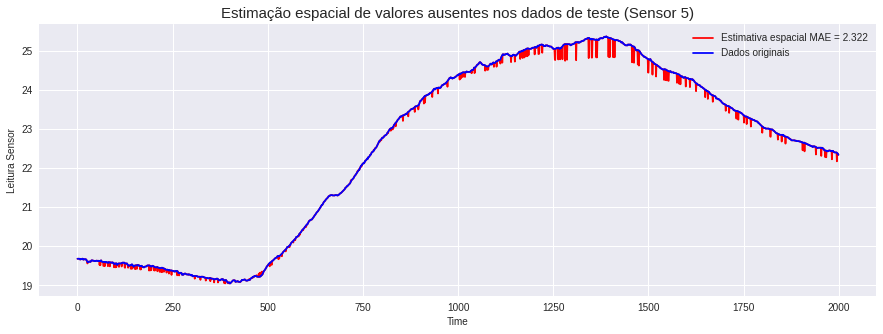

In [45]:
# Serie normal
plt.figure(figsize=(15,5))
plt.plot(esti_dados_test[4][6000:8000], 'r', 
         label='Estimativa espacial MAE = '+str(erro_estima[4])[:5])
plt.plot(Xte[0:,4][6000:8000],'b', label='Dados originais')
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.legend()
plt.title('Estimação espacial de valores ausentes nos dados de teste (Sensor 5)', fontsize=15)
plt.savefig("resultados/2.3/estima_espacial.png", bbox_inches='tight')
plt.show()

In [46]:
# Estimativa por media dos dados de treinamento
# Estimativa por valor anterio
def estiMean(dados_test, index_imput, vetor_medias):
    dodos_esti_mean = dados_test.T.copy()
    dodos_esti_valor = dados_test.T.copy()
    for i in range(0, 52):
        st_index = sorted(index_imput[i])
        for j in st_index:
            # Substituindo os dados pela media
            dodos_esti_mean[i][j] = vetor_medias[i][0]
            # Substituindo pelo valor anterior
            dodos_esti_valor[i][j] = dodos_esti_valor[i][j-1]
    return dodos_esti_valor, dodos_esti_mean

In [47]:
esti_val_anterior, esti_media = estiMean(Xte, index_data_imput, list_mi)

In [48]:
# Calculando o erro da media
erro_est_media = MAE(esti_media, Xte)
print(erro_est_media)

[34.09249358974359, 25.84055769230765, 28.915028178418765, 24.21295833333338, 24.539211738782075, 23.53165705128206, 27.215684829059803, 29.81815504807691, 26.007302350427363, 28.132348290598294, 31.575060964209424, 20.492757812499985, 28.147430755876087, 32.25939316239313, 27.604589209401702, 32.264441239316234, 38.20803952991455, 43.015475961538485, 73.80533012820511, 64.30595579594014, 57.998995793269266, 71.3309134615384, 76.88273637820514, 61.808046207265065, 53.991486645299254, 67.48521901709405, 57.3891965811965, 66.19337099358975, 57.457190504807755, 64.01145779914536, 42.39821193910264, 39.869792668269255, 32.27033653846156, 40.596796875000024, 35.305035924145244, 45.24954326923072, 37.38795239049145, 39.199009615384604, 46.2016677350428, 48.79967574786326, 39.42859548611117, 43.95151322115387, 35.2932998798077, 32.36634615384613, 38.2752374465812, 33.06463928952994, 38.20420673076925, 39.64228725961539, 30.346726963141002, 32.59320198985044, 34.01754567307694, 33.929849626068

In [49]:
# Calculando o erro com a substituicao com o valor anterior
erro_est_val = MAE(esti_val_anterior, Xte)
print(erro_est_val)

[0.2688461538461543, 0.1715384615384615, 0.21288461538461506, 0.16980769230769263, 0.15865384615384562, 0.16942307692307718, 0.150769230769231, 0.17230769230769227, 0.18730769230769276, 0.17423076923076772, 0.14423076923076944, 0.22173076923076795, 0.13115384615384706, 0.31807692307692254, 0.22980769230769205, 0.17576923076923087, 0.21923076923076895, 0.22480769230769262, 0.33788461538461645, 0.3523076923076913, 2.5123076923076857, 0.5123076923076917, 0.3078846153846159, 0.33807692307692305, 0.20692307692307854, 0.31115384615384706, 0.21230769230769161, 0.25769230769230705, 0.2638461538461542, 0.29365384615384466, 0.3003846153846159, 0.23057692307692382, 0.24576923076923027, 0.29653846153846236, 0.2307692307692299, 0.31730769230769224, 0.17846153846153837, 0.27903846153846235, 0.25576923076923086, 0.3221153846153832, 0.2301923076923083, 0.2994230769230778, 0.28673076923077073, 0.2751923076923092, 0.30999999999999933, 0.2301923076923083, 0.3194230769230766, 0.27442307692307766, 0.276153

In [50]:
sum(erro_est_val)/52

0.29064349112426036

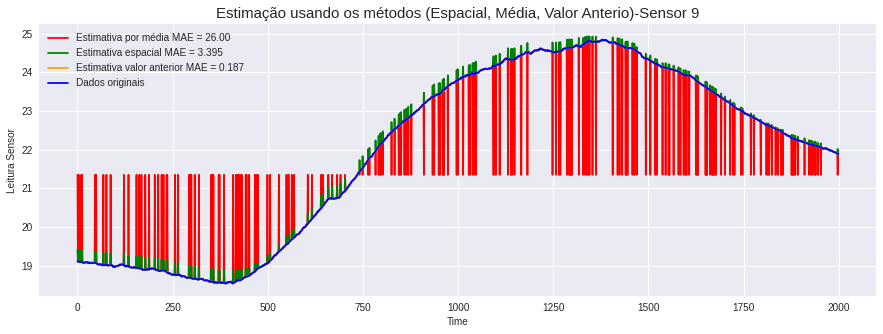

In [51]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(esti_media[8][6000:8000],'r', 
         label='Estimativa por média MAE = '+str(erro_est_media[8])[:5])
plt.plot(esti_dados_test[8][6000:8000], 'g', 
         label='Estimativa espacial MAE = '+str(erro_estima[8])[:5])
plt.plot(esti_val_anterior[8][6000:8000],color='orange', 
         label='Estimativa valor anterior MAE = '+str(erro_est_val[8])[:5])

plt.plot(Xte[0:,8][6000:8000],'b', label='Dados originais')
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('Estimação usando os métodos (Espacial, Média, Valor Anterio)-Sensor 9', fontsize=15)
plt.savefig("resultados/2.3/estima_media.png", bbox_inches='tight')
plt.show()

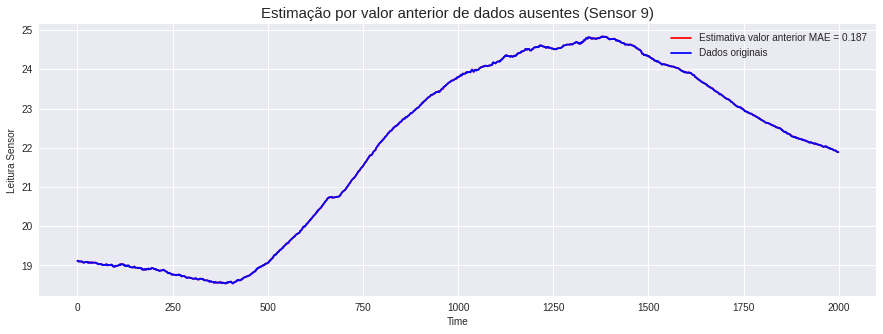

In [52]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(esti_val_anterior[8][6000:8000],color='r', 
         label='Estimativa valor anterior MAE = '+str(erro_est_val[8])[:5])
plt.plot(Xte[0:,8][6000:8000],'b', label='Dados originais')
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('Estimação por valor anterior de dados ausentes (Sensor 9)', fontsize=15)
plt.savefig("resultados/2.3/estima_val_ante.png", bbox_inches='tight')
plt.show()

### 2.3.2. Imputação com estimação temporal
Na imputação com estimação temporal, repete-se o mesmo procedimento da subseção 2.3.1 sendo a diferença em como $Xtr_i$ é obtida. Neste caso, $Xtr_i$ e formada por $st_{i,.}$ e
versães de $st_{i,.}$ atrasadas no tempo, ou seja, $Xtr_j = [st_{i,j} , st_{i−1,j} , st_{i−2,j} , st_{i−3,j} ]$. Todo orestante do procedimento é o mesmo da subseção 2.3.1.

In [53]:

# Realizando o atraso nas series (Xtrj)
Xtrj = []
for j in range(0, 52): # As 52 series
    stj = Xtr[:,j]
    st_atra_3 = []
    st_atra_3.append(stj)
    # Os tres valores de atraso
    for k in range(1, 4): #  k = 1, 2, 3
        stj_atra = []
        # 0 a 5760, percorrendo todos os valores da serie
        for i in range(0, stj.shape[0]):
            stj_atra.append(stj[i-k])
        # Pegando a serie atrasada com -1, -2, -3
        st_atra_3.append(stj_atra)
    # Adicionando a serie j e as tres atrasadas
    Xtrj.append(st_atra_3)
            

In [54]:
np.array(Xtrj).shape

(52, 4, 5760)

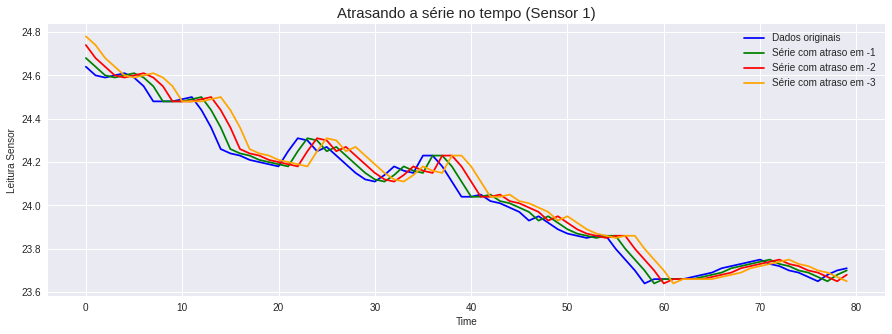

In [55]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(Xtrj[0][0][1020:1100],'b', label='Dados originais')
plt.plot(Xtrj[0][1][1020:1100],'g', 
         label='Série com atraso em -1')
plt.plot(Xtrj[0][2][1020:1100],'r', 
         label='Série com atraso em -2')

plt.plot(Xtrj[0][3][1020:1100],color='orange', 
         label='Série com atraso em -3')
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('Atrasando a série no tempo (Sensor 1)', fontsize=15)
plt.savefig("resultados/2.3/atrso_temp01.png", bbox_inches='tight')
plt.show()

In [56]:
# Criando as matrizes de covariancia da estimacao temporal
Xtrj = np.array(Xtrj)
list_Cx_j_Ro, list_mj = meanCxM(Xtrj)

In [57]:
list_Cx_j_Ro[0]

array([[6.22785792, 6.22709283, 6.22577365, 6.22411158],
       [6.22709283, 6.22785792, 6.22709283, 6.22577365],
       [6.22577365, 6.22709283, 6.22785792, 6.22709283],
       [6.22411158, 6.22577365, 6.22709283, 6.22785792]])

In [58]:
# Colculando os coeficientes ('a, b) para todas as series atrasadas 
coe_estima_xj = estimaLinear(list_Cx_j_Ro, list_mj)

In [59]:
# Estimendo os valores amputados (Estimação temporal)
def estTem(coe_estima, dados_test, posi_imput):
    novos_dados = dados_test.T.copy()
    dados_test = dados_test.T
    for i in range(0, 52):
        a = coe_estima[i][0] # Coeficiente a 1x3 da serie i
        b = coe_estima[i][1] # Coeficiente b 1x1 ca serie i
        index_imput = sorted(posi_imput[i]) # Os index de onde foram imputados os dados da serie i
        # Estimar todos os dados imputados da serie i
        for j in index_imput:
            Y = []
            Y.append(dados_test[i][j-1])
            Y.append(dados_test[i][j-2])
            Y.append(dados_test[i][j-3])
            # Estimando o valor cm os coeficentes da serie i
            X_i = np.dot(a.T, Y) + b
            # Substituido os dados faltosos pela estimativa 
            novos_dados[i][j] = X_i
    # Retornando os dados de teste com os valores imputados substituidos        
    return novos_dados

In [60]:
# Estimando os novos dados de testes (estimacao temporal)
est_temp_dados_test = estTem(coe_estima_xj, Xte, index_data_imput)

In [61]:
# Calculando o erro com a estimacao temporal
erro_est_temp = MAE(est_temp_dados_test, Xte)
print(erro_est_temp)

[0.2379575043611904, 0.13392972586935395, 0.1816945285365553, 0.1478782243316548, 0.13140661488738095, 0.15850183048532143, 0.12906563436123744, 0.16084105191796946, 0.14603773167575057, 0.14763813253478103, 0.11539493801225312, 0.17401858760565922, 0.11268758838372957, 0.49201799961707454, 0.47735584089213845, 0.5169412709692628, 0.18991896382243922, 0.4009603137910718, 0.3089235338106767, 0.3273862301360849, 2.3952355996930472, 0.884932888583419, 0.2576829899218001, 0.3020546374314786, 0.1632261190054484, 0.2708810284944155, 0.15980790469944844, 0.15104736686547096, 0.19111001253732884, 0.5100785553767081, 0.22563079176713685, 0.21290145889191406, 0.20776813335926464, 0.2911318965966413, 0.1967067432455316, 0.267260131189005, 0.13343213056200579, 0.19577926153180997, 0.17882589295347603, 0.21986175158927235, 0.15434024089916595, 0.3091059967600757, 0.19102059261502466, 0.21730372986057853, 0.2846414089351884, 0.1709917796692891, 0.21036409245212656, 0.17407217913333115, 0.20281844573

In [62]:
sum(erro_est_temp)/52

0.27682882217920973

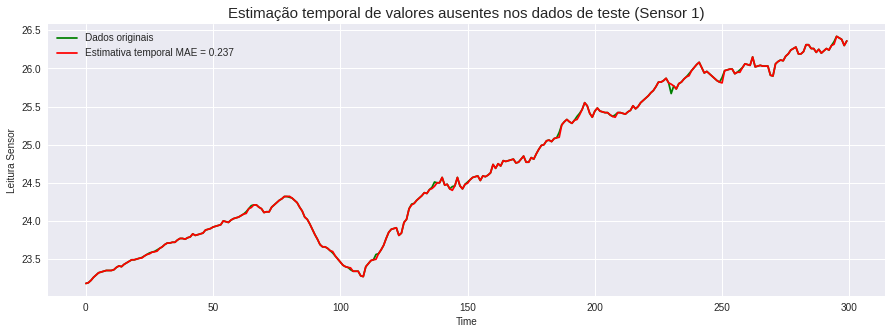

In [63]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(Xte[0:,0][700:1000],'g', label='Dados originais')
plt.plot(est_temp_dados_test[0][700:1000],'r', 
         label='Estimativa temporal MAE = '+str(erro_est_temp[0])[:5])
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('Estimação temporal de valores ausentes nos dados de teste (Sensor 1)', fontsize=15)
plt.savefig("resultados/2.3/estima_temp.png", bbox_inches='tight')
plt.show()

### 2.3.2. Imputação com estimação espaço-temporal
Na imputação com estimação temporal, repete-se o mesmo procedimento da subseção 2.3.1 sendo a diferença em como $Xtr_j$ é obtida. Neste caso, $Xtr_i$ e formada por $st_{j,.}$ e
versães de $st_{j,.}$ atrasadas no tempo, em parelhadas com $st_{.,u}, st_{.,v}, st_{.,w} $, ou seja,   $Xtr_{ij} = [st_{i,j} , st_{i−1,j} , st_{i−2,j} , st_{i−3,j}, st_{i,u}, st_{i,v}, st_{i,w} ]$. Todo orestante do procedimento é o mesmo da subseção 2.3.1.

In [64]:
# Emparelhando as series em uma matriz 
#st_{i,j} , st_{i−1,j} , st_{i−2,j} , st_{i−3,j}, st_{i,u}, st_{i,v}, st_{i,w}

In [65]:
#Xtrj  Series atrazadas no tempo
#mat_Xtr_i_Ro  Series mais similares 
list_Cx_ji = []
for i in range(0, 52):
    list_Cx_ji7 = []
    list_Cx_ji7.append(mat_Xtr_i_Ro[i][0])
    # Espacial
    for j in range(1, 4): # j = 1, 2, 3
        list_Cx_ji7.append(mat_Xtr_i_Ro[i][j])
    # Temporal
    for l in range(1, 4): # j = 1, 2, 3
        list_Cx_ji7.append(Xtrj[i][l])
    list_Cx_ji.append(list_Cx_ji7) # (52, 7, 5760)
        

In [66]:
list_Cx_ji = np.array(list_Cx_ji)
list_Cx_ji.shape

(52, 7, 5760)

In [67]:
# Criando as matrizes de covariancia da estimacao espaco-temporal
list_Cx_ij_Ro, list_mij = meanCxM(list_Cx_ji)
list_Cx_ij_Ro.shape

(52, 7, 7)

In [68]:
list_Cx_ij_Ro[0]

array([[6.22785792, 4.76523385, 5.54483379, 4.80132899, 6.22709283,
        6.22577365, 6.22411158],
       [4.76523385, 3.74797986, 4.33511113, 3.72681988, 4.76580648,
        4.76606849, 4.7660204 ],
       [5.54483379, 4.33511113, 5.09237063, 4.32379028, 5.54372832,
        5.54217149, 5.54019313],
       [4.80132899, 3.72681988, 4.32379028, 3.84936815, 4.80153401,
        4.80143632, 4.80106974],
       [6.22709283, 4.76580648, 5.54372832, 4.80153401, 6.22785792,
        6.22709283, 6.22577365],
       [6.22577365, 4.76606849, 5.54217149, 4.80143632, 6.22709283,
        6.22785792, 6.22709283],
       [6.22411158, 4.7660204 , 5.54019313, 4.80106974, 6.22577365,
        6.22709283, 6.22785792]])

In [69]:
# Estimendo os valores amputados
def estEspTem(coe_estima, posi_imput, index_sim_max3, dados_test):
    dados_test = dados_test.T # Transformnado para de 5760x52 para 52x5760
    novos_dados = dados_test.copy()
    for i in range(0, 52):
        
        a = coe_estima[i][0] # Coeficiente a 1x3 da serie i
        b = coe_estima[i][1] # Coeficiente b 1x1 ca serie i
        index_imput = sorted(posi_imput[i]) 
        # Estimar todos os dados imputados da serie i
        for j in posi_imput[i]:
            Y = []
            # Pegando os valores das similares
            Y.append(dados_test[index_sim_max3[i][0]-1][j])
            Y.append(dados_test[index_sim_max3[i][1]-1][j])
            Y.append(dados_test[index_sim_max3[i][2]-1][j])
            # Pegando os valores atrazados
            Y.append(dados_test[i][j-1])
            Y.append(dados_test[i][j-2])
            Y.append(dados_test[i][j-3])
            # Estimando o valor cm os coeficentes da serie i
            X_i = np.dot(a.T, Y) + b
            # Substituido os dados faltosos pela estimativa 
            novos_dados[i][j] = X_i
    # Retornando os dados de teste com os valores imputados substituidos        
    return novos_dados

In [70]:
# Colculando os coeficientes ('a, b) para todas as series 
coe_estima_xij = estimaLinear(list_Cx_ij_Ro, list_mij)
# Estimando os novos dados de testes (estimacao temporal)
est_esp_temp_dados = estEspTem(coe_estima_xij, index_data_imput, sim_max_rox, Xte)

In [71]:
# Calculando o erro com a estimacao temporal
erro_est_esp_temp = MAE(est_esp_temp_dados, Xte)
print(erro_est_esp_temp)

[0.24763400351346784, 0.1573405458649792, 0.18483314380778482, 0.18000087434164325, 0.20631866103798754, 0.1617302717044527, 0.2156477871867026, 0.22961310628972878, 0.16775759180266644, 0.16365315059510074, 0.15503152310097662, 0.17925170112942418, 0.11513675842311033, 1.0746864001329515, 1.3274214089516587, 2.3276497967664205, 0.21599449215855976, 1.1736040290075642, 0.41508814683719936, 0.354464467299053, 2.9480608123161147, 2.8832703331168505, 0.27577857655718885, 0.45987393919061975, 0.2702405186937013, 0.40438693723418123, 0.1962465578511774, 0.23921288780028355, 0.2401534458933309, 1.7745127332087158, 0.27511119005285367, 0.283442114608369, 0.22570871977237486, 0.316794906990281, 0.27516464073225166, 0.27090518807381003, 0.15488033408085816, 0.2486411057370901, 0.2250578007080511, 0.2244776318093828, 0.20688797326870356, 0.3634946416625061, 0.20714788410405088, 0.21931404458544543, 0.3134764010433886, 0.20882136309118443, 0.21617768937814696, 0.18733183490065816, 0.2061235546660

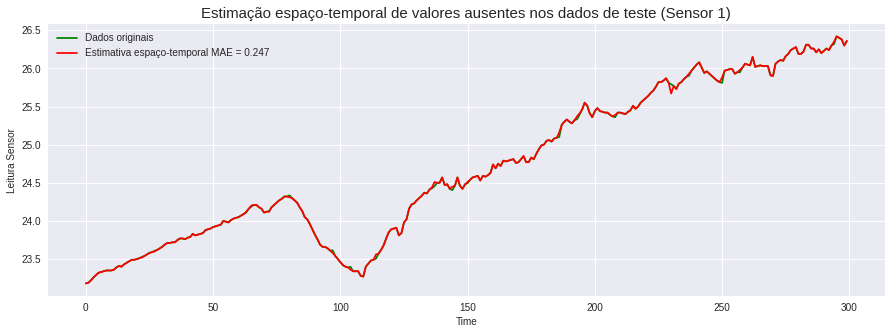

In [72]:
plt.figure(figsize=(15,5))
plt.plot(est_esp_temp_dados[0][700:1000], 'g', label='Dados originais')
plt.plot(Xte[:,0][700:1000], 'r', 
         label='Estimativa espaço-temporal MAE = '+str(erro_est_esp_temp[0])[:5])
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.legend()
plt.title('Estimação espaço-temporal de valores ausentes nos dados de teste (Sensor 1)', fontsize=15)
plt.savefig("resultados/2.3/estima_espa-temp.png", bbox_inches='tight')
plt.show()

In [73]:
sum(erro_est_esp_temp)/52

0.46164163574766987

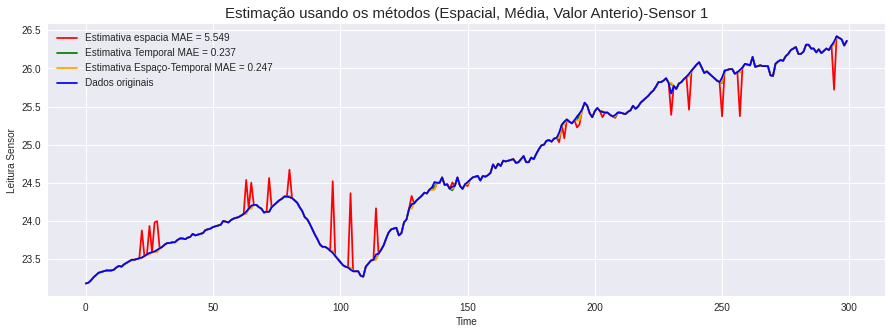

In [74]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(esti_dados_test[0][700:1000],'r', 
         label='Estimativa espacia MAE = '+str(erro_estima[0])[:5])
plt.plot(est_temp_dados_test[0][700:1000], 'g', 
         label='Estimativa Temporal MAE = '+str(erro_est_temp[0])[:5])
plt.plot(esti_val_anterior[0][700:1000],color='orange', 
         label='Estimativa Espaço-Temporal MAE = '+str(erro_est_esp_temp[0])[:5])

plt.plot(Xte[0:,0][700:1000],'b', label='Dados originais')
plt.legend()
plt.xlabel("Time", size = 10,)
plt.ylabel("Leitura Sensor", size = 10)
plt.title('Estimação usando os métodos (Espacial, Média, Valor Anterio)-Sensor 1', fontsize=15)
plt.savefig("resultados/2.3/estima_all.png", bbox_inches='tight')
plt.show()

In [75]:
# Salvando os dados das tebelas do item 2.3
estima_txt = []
estima_txt.append(erro_estima)
estima_txt.append(erro_est_media)
estima_txt.append(erro_est_val)
estima_txt.append(erro_est_temp)
estima_txt.append(erro_est_esp_temp)
estima_txt = np.array(estima_txt)
np.savetxt('resultados/2.3/estima_erro_01.txt', estima_txt.T, fmt='%4.3f', delimiter='&')

## 2.4 Tratamento de outliers baseada em predição utilizando matriz de correlação

In [76]:
# Criando as series de diferenca dos dados de teste
list_serie_difere = []
for i in range(0, 52):
    str_dife = []
    str_dife.append(0)
    for j in range(1, Xtr.shape[0]):
        str_dife.append(Xtr[:,i][j] - Xtr[:,i][j-1])
    list_serie_difere.append(str_dife)
list_serie_difere = np.array(list_serie_difere)
list_serie_difere.shape

(52, 5760)

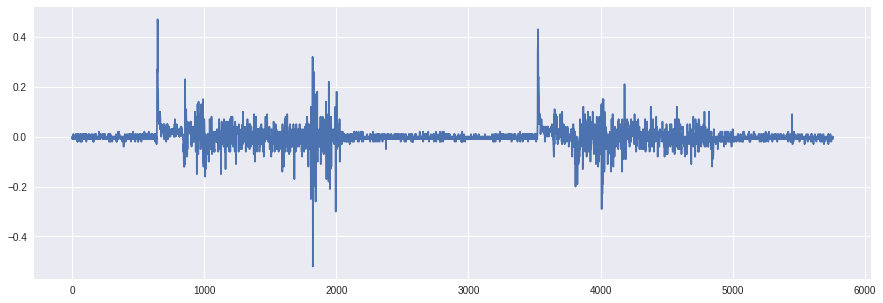

In [77]:
plt.figure(figsize=(15,5))
plt.plot(list_serie_difere[0])

In [78]:
print(list_serie_difere[0])

[ 0.   -0.01 -0.01 ...  0.    0.    0.  ]


In [79]:
# Inserindo os autliers
X_auliers = Xte.T.copy()
# Desvio padrao das seres de diferenca
dpdXi = np.std(list_serie_difere, axis=1)
list_index_aut = []
rng = np.random.default_rng()
for i in range(0, 52):
    # Pegando 5% dos index de forma aleatoria de todas as series de teste
    index_aut = rng.choice(range(4, Xte.shape[0]), size=(int(Xte.shape[0] * 0.05)), replace=False)
    for j in index_aut:
        X_auliers[i][j] = X_auliers[i][j] + (5 * dpdXi[i])
    # Quardando as posicoes dos autliers
    list_index_aut.append(index_aut)
    

In [80]:
X_auliers.shape

(52, 8640)

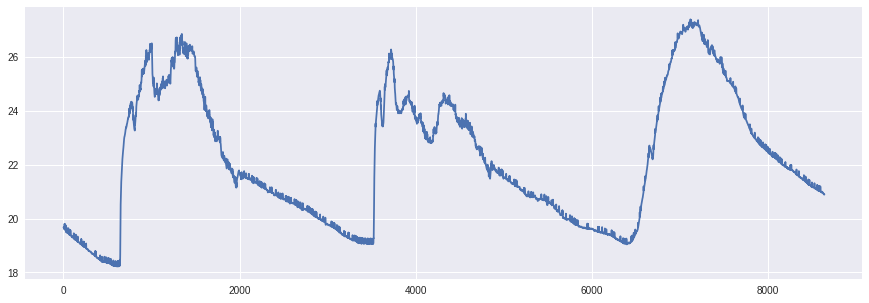

In [81]:
plt.figure(figsize=(15,5))
plt.plot(X_auliers[0])

In [82]:
# Fazendo a identificacao dos autliers
list_result_aut = []
dados_test = Xte.T.copy()
for i in range(0, 52):
    a = coe_estima_xj[i][0] # Coeficiente a 1x3 da serie i
    b = coe_estima_xj[i][1] # Coeficiente b 1x1 ca serie i
    aut_result = []
    for j in range(4, X_auliers.shape[1]):
        Y = []
        Y.append(dados_test[i][j-1])
        Y.append(dados_test[i][j-2])
        Y.append(dados_test[i][j-3])
        # Estimando o valor cm os coeficentes da serie i
        X_i = np.dot(a.T, Y) + b
        
        if abs(X_auliers[i][j] - X_i) > 4 * dpdXi[i]:
            aut_result.append(j)
    list_result_aut.append(aut_result)

In [83]:
# Caculando os FPs e FNs
list_vp, list_vn, list_fp, list_fn  = [],[],[],[]
for i in range(0, 52):
    vp = 0
    fp = 0
    for j in range(0, len(list_result_aut[i])):
        result_aut = list_result_aut[i][j]       
        if result_aut in list(list_index_aut[i]):
            vp += 1
            
        if result_aut not in list(list_index_aut[i]):
            fp += 1
    vn = len(list_index_aut[i]) - fp      
    fn = len(list_index_aut[i]) - vp 
    list_vp.append(vp)
    list_vn.append(vn)
    list_fp.append(fp)
    list_fn.append(fn)       

In [84]:
print("Verdadeiros Positivo: ", list_vp)
print("Verdadeiro Negativos: ", list_vn)
print("Falsos Positivos: ", list_fp)
print("Falsos Negativos: ", list_fn)

Verdadeiros Positivo:  [410, 417, 422, 418, 430, 423, 424, 426, 431, 432, 430, 423, 432, 432, 432, 432, 428, 432, 429, 431, 395, 431, 431, 424, 430, 426, 430, 431, 425, 432, 419, 424, 422, 426, 424, 419, 425, 428, 428, 428, 429, 430, 430, 427, 425, 429, 428, 428, 429, 429, 430, 431]
Verdadeiro Negativos:  [397, 419, 417, 418, 413, 425, 421, 424, 422, 425, 427, 420, 428, 432, 432, 432, 425, 432, 422, 423, 392, 430, 419, 419, 422, 427, 424, 422, 426, 432, 404, 422, 418, 418, 419, 418, 424, 423, 419, 427, 423, 419, 425, 425, 424, 422, 427, 427, 423, 426, 426, 424]
Falsos Positivos:  [35, 13, 15, 14, 19, 7, 11, 8, 10, 7, 5, 12, 4, 0, 0, 0, 7, 0, 10, 9, 40, 2, 13, 13, 10, 5, 8, 10, 6, 0, 28, 10, 14, 14, 13, 14, 8, 9, 13, 5, 9, 13, 7, 7, 8, 10, 5, 5, 9, 6, 6, 8]
Falsos Negativos:  [22, 15, 10, 14, 2, 9, 8, 6, 1, 0, 2, 9, 0, 0, 0, 0, 4, 0, 3, 1, 37, 1, 1, 8, 2, 6, 2, 1, 7, 0, 13, 8, 10, 6, 8, 13, 7, 4, 4, 4, 3, 2, 2, 5, 7, 3, 4, 4, 3, 3, 2, 1]


In [85]:
dados_aut_txt = np.array([list_fp, list_fn])
np.savetxt('resultados/2.4/estima_autliers.txt', dados_aut_txt.T, fmt='%4.f', delimiter='&')